# Day 1: SHAP & LIME for Model Interpretability

In [21]:
#download data from kaggle
!pip install opendatasets --quiet

In [22]:
!pip install shap lime --quiet

In [23]:
!pip install -U scikit-learn==1.7.1

In [24]:
import shap
import joblib
import pandas as pd
import numpy as np
import opendatasets as od

In [25]:
od.download("https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data?select=loan_data.csv")
#hemantk777  721b095dacb7cfa6129768282921b8fb

Skipping, found downloaded files in "./loan-approval-classification-data" (use force=True to force download)


In [26]:
data=pd.read_csv("/content/loan-approval-classification-data/loan_data.csv")

In [27]:
# Load your pipeline and data
pipeline = joblib.load("/content/loan_pipeline.pkl")

In [28]:
pipeline.named_steps

{'preprocess': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['person_age', 'person_income',
                                   'person_emp_exp', 'loan_amnt',
                                   'loan_int_rate', 'loan_percent_income',
                                   'cb_person_cred_hist_length',
                                   'credit_score']),
                                 ('cat',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['person_gender', 'person_education',
                                   'person_home_ownership', 'loan_intent',
                                   'previous_loan_defaults_on_file'])]),
 'model': LogisticRegression()}

In [29]:
# Get transformed feature names from ColumnTransformer
feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()

In [30]:
# Drop target column for SHAP
X = data.drop("loan_status", axis=1)

# Select only 100 rows to speed up SHAP computation
X_sample = X.sample(100, random_state=42)

# Get preprocessed numeric features
X_transformed = pipeline.named_steps['preprocess'].transform(X_sample)
# Convert transformed array back to DataFrame with correct column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

## SHAP

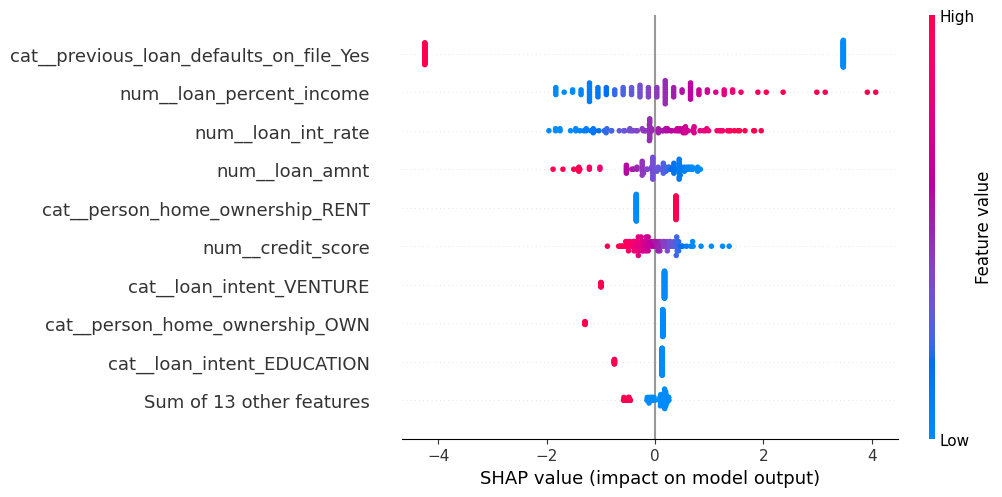

In [31]:
# SHAP Explainer (works best for tree models like XGBoost)
explainer = shap.Explainer(pipeline.named_steps['model'], X_transformed_df)

# SHAP values
shap_values = explainer(X_transformed_df)

# Plot global importance
shap.plots.beeswarm(shap_values)

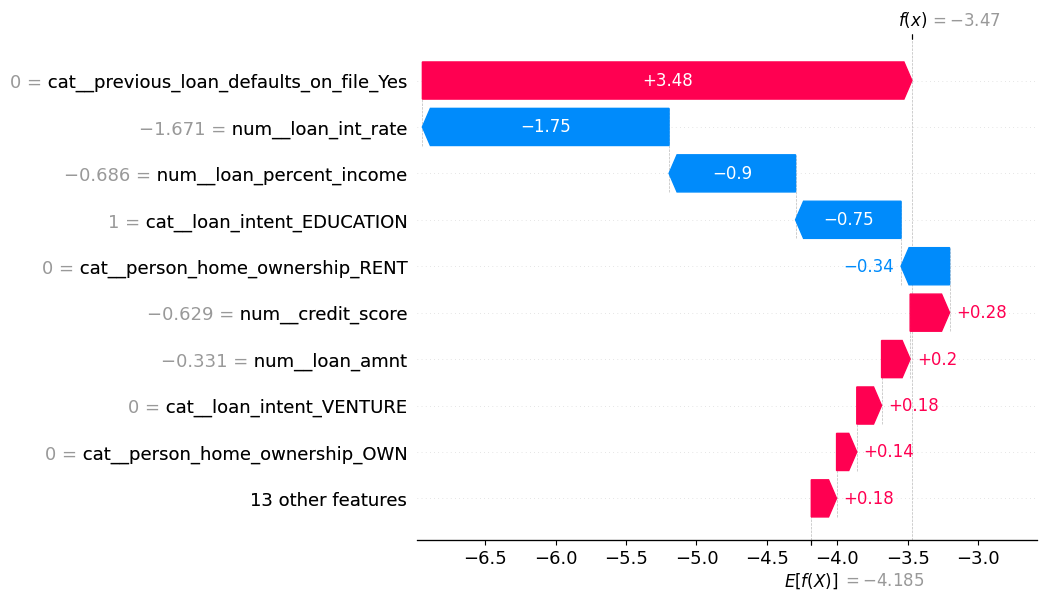

In [32]:
# 🔍 Local Explanation for a Single Prediction
row = X_sample.iloc[[0]]   # Choose a single row

shap.plots.waterfall(shap_values[0])    # SHAP force plot

## LIME

In [33]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [34]:
X_transformed_lime = pipeline.named_steps['preprocess'].transform(X)

In [35]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed_lime,
    feature_names=feature_names,
    class_names=["Not Approved", "Approved"],
    mode="classification"
)

In [36]:
pipeline.named_steps["model"].predict_proba

<bound method LogisticRegression.predict_proba of LogisticRegression()>

In [37]:
# Explain a single instance
exp = explainer.explain_instance(
    data_row=X_transformed[0],
    predict_fn=pipeline.named_steps["model"].predict_proba
)

exp.show_in_notebook(show_table=True)